In [14]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from IPython.display import HTML, display

from sentence_transformers import SentenceTransformer
from captum.attr import IntegratedGradients

# Configurar dispositivo (GPU si es posible)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"🚀 Ejecutando en: {device}")

# Rutas (Asegúrate de que coinciden con tus archivos)
PATH_MODELO = "./modelo_contrastivo_autores_2"
PATH_CENTROIDES = "centroides_autores_2.csv"

🚀 Ejecutando en: cpu


In [15]:
def cargar_recursos(ruta_modelo, ruta_centroides):
    print(f"⏳ Cargando modelo desde: {ruta_modelo}...")
    try:
        model = SentenceTransformer(ruta_modelo).to(device)
        model.eval()
        tokenizer = model.tokenizer
    except Exception as e:
        print(f"❌ Error cargando modelo: {e}")
        return None, None, None

    print(f"⏳ Cargando centroides desde: {ruta_centroides}...")
    try:
        df = pd.read_csv(ruta_centroides)
        # Convertir explícitamente a tipos numéricos para evitar errores de numpy
        print(f"✅ Cargado. Autores disponibles: {len(df)}")
        return model, tokenizer, df
    except Exception as e:
        print(f"❌ Error cargando CSV: {e}")
        return None, None, None

# Ejecutar carga
model, tokenizer, df_centroides = cargar_recursos(PATH_MODELO, PATH_CENTROIDES)

⏳ Cargando modelo desde: ./modelo_contrastivo_autores_2...


The tokenizer you are loading from './modelo_contrastivo_autores_2' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


⏳ Cargando centroides desde: centroides_autores_2.csv...
✅ Cargado. Autores disponibles: 6


In [16]:
def explicar_estilo_autor(texto, autor_objetivo, model, tokenizer, df_centroides):
    """
    Calcula qué palabras acercan el texto al estilo del autor objetivo.
    Maneja la proyección (Dense Layer) de DistilBERT.
    """
    
    # 1. Preparar Centroide (Objetivo)
    if autor_objetivo not in df_centroides['autor'].values:
        raise ValueError(f"Autor '{autor_objetivo}' no encontrado.")
    
    # Extraer vector y convertir a float32 explícitamente
    vector_autor = df_centroides[df_centroides['autor'] == autor_objetivo].iloc[0, 1:].values
    centroide = np.array(vector_autor, dtype=np.float32)
    centroide_tensor = torch.tensor(centroide, device=device).unsqueeze(0) # (1, 512)

    # 2. Desglosar el Modelo
    # model[0] = Transformer, model[1] = Pooling, model[2] = Dense
    base_model = model[0].auto_model.to(device)
    embedding_layer = base_model.embeddings.word_embeddings
    
    # Detectar si existe capa de proyección (model[2])
    projection_layer = model[2].linear if len(model) > 2 else None

    # 3. Preparar Input
    encoded = tokenizer(texto, return_tensors='pt', truncation=True, padding=True).to(device)
    input_ids = encoded["input_ids"]
    attention_mask = encoded["attention_mask"]
    input_embeddings = embedding_layer(input_ids) # Input para IG

    # 4. Definir Forward Personalizado (Simula el paso completo del modelo)
    def forward_similarity(inputs_embeds, mask):
        # A. Transformer
        outputs = base_model(inputs_embeds=inputs_embeds, attention_mask=mask)
        token_embeddings = outputs.last_hidden_state
        
        # B. Mean Pooling
        input_mask_expanded = mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
        sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
        pooled_embedding = sum_embeddings / sum_mask # (Batch, 768)
        
        # C. Proyección Densa (768 -> 512)
        if projection_layer is not None:
            final_embedding = projection_layer(pooled_embedding)
            final_embedding = torch.tanh(final_embedding)
        else:
            final_embedding = pooled_embedding

        # D. Similitud Coseno
        cos_sim = torch.nn.functional.cosine_similarity(final_embedding, centroide_tensor)
        return cos_sim

    # 5. Ejecutar Integrated Gradients
    ig = IntegratedGradients(forward_similarity)
    attributions = ig.attribute(
        inputs=input_embeddings,
        additional_forward_args=(attention_mask,),
        n_steps=30
    )
    
    # Procesar resultados
    importancias = attributions.sum(dim=-1).squeeze(0).detach().cpu().numpy()
    tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze(0))
    
    # Limpieza
    tokens_l, scores_l = [], []
    for t, s in zip(tokens, importancias):
        if t in ["[CLS]", "[SEP]", "[PAD]"]: continue
        tokens_l.append(t.replace("##", ""))
        scores_l.append(s)

    # Normalizar (-1 a 1)
    scores_arr = np.array(scores_l)
    max_val = np.max(np.abs(scores_arr))
    norm_scores = scores_arr / (max_val + 1e-9) if max_val > 0 else scores_arr
    
    return tokens_l, norm_scores

In [17]:
def visualizar_heatmap(tokens, scores, autor_objetivo):
    cmap = cm.get_cmap("bwr") # Azul-Blanco-Rojo
    html = f"<h3 style='color:#333'>Análisis de estilo: {autor_objetivo}</h3>"
    html += "<div style='line-height:1.8; border:1px solid #ccc; padding:15px; background:white; border-radius:8px;'>"
    
    for token, score in zip(tokens, scores):
        # Color: 0.5 es neutro (blanco)
        color_val = (score + 1) / 2 
        rgba = cmap(color_val)
        hex_color = mcolors.rgb2hex(rgba)
        
        # Color de la fuente para contraste
        text_color = "white" if abs(score) > 0.4 else "black"
        
        html += f"<span style='background-color:{hex_color}; color:{text_color}; padding:2px 4px; border-radius:4px; margin:0 2px' title='{score:.3f}'>{token}</span>"
        
    html += "</div><p style='font-size:12px; color:gray'>🔴 Rojo: Muy característico del autor | 🔵 Azul: Poco característico</p>"
    display(HTML(html))

def predecir_autor(texto, model, df):
    # Encoding rápido para predicción
    emb = model.encode([texto], convert_to_numpy=True)[0]
    best_sim = -1
    best_autor = "Desconocido"
    
    for idx, row in df.iterrows():
        # Convertir string CSV a array float
        centroide = np.array(row[1:].values, dtype=np.float32)
        sim = np.dot(emb, centroide) / (np.linalg.norm(emb) * np.linalg.norm(centroide))
        if sim > best_sim:
            best_sim = sim
            best_autor = row['autor']
            
    return best_autor, best_sim

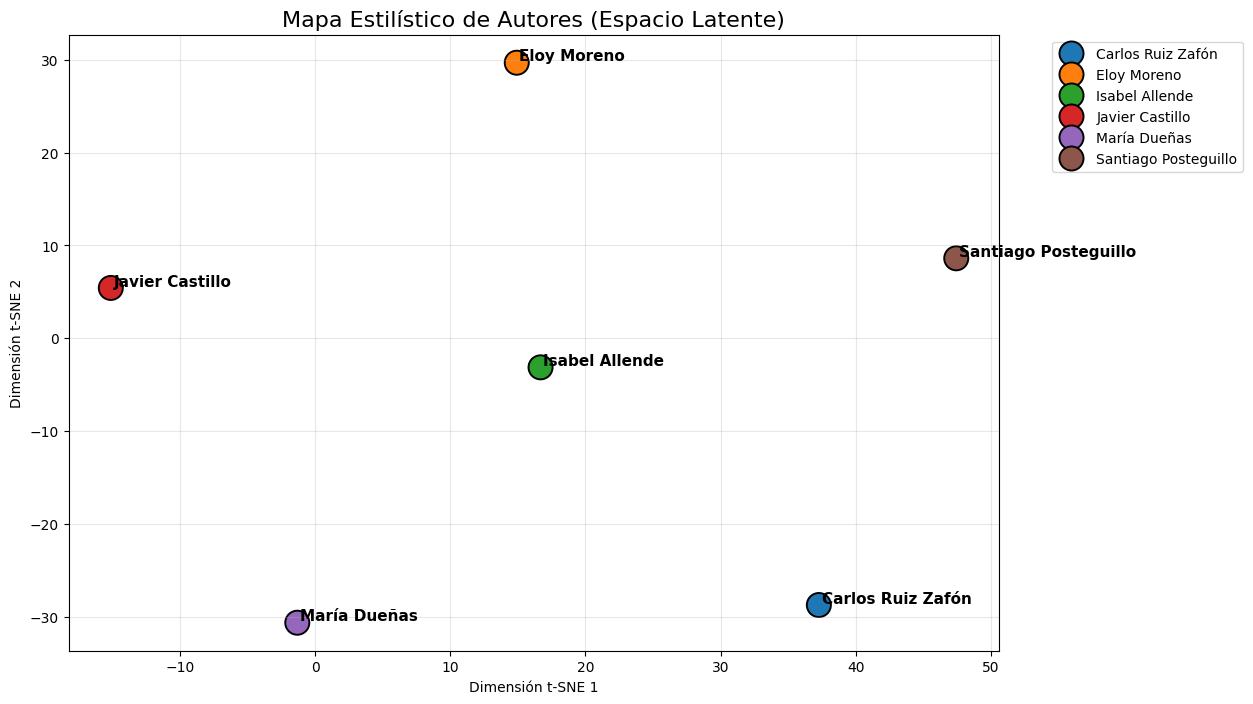

In [18]:
# Preparar datos para t-SNE
autores_labels = df_centroides["autor"].values
vectores = df_centroides.iloc[:, 1:].values.astype(np.float32)

tsne = TSNE(n_components=2, perplexity=min(5, len(autores_labels)-1), random_state=42, init='pca', learning_rate='auto')
proyeccion = tsne.fit_transform(vectores)

# Plot
plt.figure(figsize=(12, 8))
sns.scatterplot(x=proyeccion[:,0], y=proyeccion[:,1], hue=autores_labels, s=300, palette="tab10", edgecolor='black')

for i, txt in enumerate(autores_labels):
    plt.text(proyeccion[i,0]+0.2, proyeccion[i,1]+0.2, txt, fontsize=11, weight='bold')

plt.title("Mapa Estilístico de Autores (Espacio Latente)", fontsize=16)
plt.xlabel("Dimensión t-SNE 1")
plt.ylabel("Dimensión t-SNE 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()

🤖 El modelo cree que este texto es de: CARLOS RUIZ ZAFÓN (Confianza: 0.553)
⏳ Generando explicación de estilo...


C:\Users\marko\AppData\Local\Temp\ipykernel_11388\1106478704.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("bwr") # Azul-Blanco-Rojo


C:\Users\marko\AppData\Local\Temp\ipykernel_11388\3987093643.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_plot, x='token', y='score', palette='bwr')


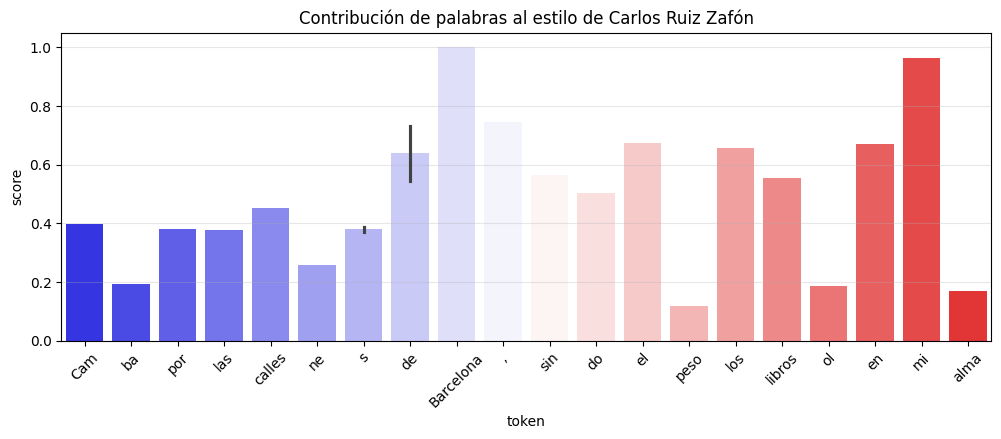

In [19]:
TEXTO_A_ANALIZAR = """
Caminaba por las calles nebulosas de Barcelona, sintiendo el peso de los libros olvidados en mi alma.
"""

# 1. Predicción Automática
autor_predicho, confianza = predecir_autor(TEXTO_A_ANALIZAR, model, df_centroides)
print(f"🤖 El modelo cree que este texto es de: {autor_predicho.upper()} (Confianza: {confianza:.3f})")

# 2. Explicación Visual
print(f"⏳ Generando explicación de estilo...")
tokens, scores = explicar_estilo_autor(TEXTO_A_ANALIZAR, autor_predicho, model, tokenizer, df_centroides)

# Mostrar Heatmap
visualizar_heatmap(tokens, scores, autor_predicho)

# 3. Gráfico de Barras de Importancia
plt.figure(figsize=(12, 4))
df_plot = pd.DataFrame({'token': tokens, 'score': scores})
# Filtrar tokens poco relevantes para limpiar el gráfico
df_plot = df_plot[df_plot['score'].abs() > 0.1] 

sns.barplot(data=df_plot, x='token', y='score', palette='bwr')
plt.xticks(rotation=45)
plt.title(f"Contribución de palabras al estilo de {autor_predicho}")
plt.grid(axis='y', alpha=0.3)
plt.show()